In [56]:
# + tags=[]
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box, Point
import numpy as np
%matplotlib inline

## 1. AIS-Datenvorverarbeitung: Filterung, Δt-Berechnung & Cargo-Klassifikation

In [78]:
import pandas as pd

# ───────────────────────────────────────────────────────────────────────
# 1) CSV einlesen
# ───────────────────────────────────────────────────────────────────────
df = pd.read_csv(
    "data/processed/ais/fehmarnbelt_ais_filtered_no_ship_type.csv",
    parse_dates=["# Timestamp"],
    dtype={"MMSI": str},
    low_memory=False
)
print(f"Ursprüngliche Zeilen: {len(df):,}")

# ───────────────────────────────────────────────────────────────────────
# 2) AIS-Filter (ohne Config) anwenden
#    – Type of mobile ∈ {Class A, Class B}
#    – Navigational status == "Under way using engine"
#    – Type of position fixing device == "GPS"
# ───────────────────────────────────────────────────────────────────────
df = df[df["Type of mobile"].isin(["Class A", "Class B"])]
print(f"Nach Type of mobile-Filter: {len(df):,}")

df = df[df["Navigational status"] == "Under way using engine"]
print(f"Nach Navigational status-Filter: {len(df):,}")

df = df[df["Type of position fixing device"] == "GPS"]
print(f"Nach Position fixing device-Filter: {len(df):,}")

# ───────────────────────────────────────────────────────────────────────
# 3) Δt-Spalte berechnen
#    – sortiert nach MMSI und Timestamp
#    – diff() innerhalb jeder MMSI-Gruppe
#    – in Sekunden umwandeln, erstes Δt = 0
# ───────────────────────────────────────────────────────────────────────
df = df.sort_values(["MMSI", "# Timestamp"]).reset_index(drop=True)
df["delta_t"] = (
    df.groupby("MMSI")["# Timestamp"]
      .diff()
      .dt.total_seconds()
      .fillna(0)
)
print("Δt-Spalte hinzugefügt (Sekunden)")

# ───────────────────────────────────────────────────────────────────────
# 4) Zielvariable anlegen: Cargo vs. Nicht-Cargo
# ───────────────────────────────────────────────────────────────────────
df["is_cargo"] = (df["Ship type"] == "Cargo").astype(int)

# ───────────────────────────────────────────────────────────────────────
# 5) Klassenverteilung prüfen
# ───────────────────────────────────────────────────────────────────────
counts = df["is_cargo"].value_counts().rename({1: "Cargo", 0: "Other"})
print("\nKlassenverteilung nach Filterung:")
print(counts)


# ───────────────────────────────────────────────────────────────────────
# 6) Kurzer Blick auf einige Schlüssel-Features inkl. Δt und ROT
# ───────────────────────────────────────────────────────────────────────
print("\nBeispieldaten:")
print(
    df[
        ["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT", "is_cargo"]
    ]
    .sample(10, random_state=42)
    .reset_index(drop=True)
)

Ursprüngliche Zeilen: 193,706
Nach Type of mobile-Filter: 193,706
Nach Navigational status-Filter: 193,706
Nach Position fixing device-Filter: 193,706
Δt-Spalte hinzugefügt (Sekunden)

Klassenverteilung nach Filterung:
is_cargo
Other    135191
Cargo     58515
Name: count, dtype: int64

Beispieldaten:
    SOG    COG  Draught  Width  Length  delta_t  ROT  is_cargo
0   0.5  343.8      1.9    8.0    19.0      2.0  NaN         0
1   8.4  114.1      2.4   12.0    88.0     11.0  NaN         1
2   0.0  202.0      2.6   10.0    25.0     11.0  0.0         0
3  12.4   43.0      6.1   24.0   142.0     10.0  3.6         0
4   9.7   94.0      5.5   12.0    90.0     10.0  0.0         1
5   0.0  346.8      2.6   10.0    25.0     10.0  NaN         0
6  10.5  293.1      5.9   13.0    89.0     10.0  0.0         1
7  11.8  296.8      7.3   38.0   252.0     10.0 -1.1         0
8  15.9  206.0      5.3   24.0   141.0      6.0  0.0         0
9   0.8   55.4      2.1    7.0    21.0     11.0  NaN         0


# 2. Fehlende Werte

In [79]:
# ───────────────────────────────────────────────────────────────────────
# 7) Fehlende Werte prüfen
# ───────────────────────────────────────────────────────────────────────
cols_of_interest = ["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT"]
missing = df[cols_of_interest].isna().sum()
missing_pct = (missing / len(df) * 100).round(2)

missing_summary = pd.DataFrame({
    "missing_count": missing,
    "missing_pct":   missing_pct
})
print("\nFehlende Werte pro Spalte:")
print(missing_summary)


Fehlende Werte pro Spalte:
         missing_count  missing_pct
SOG               1166         0.60
COG               1166         0.60
Draught           3706         1.91
Width                0         0.00
Length               0         0.00
delta_t              0         0.00
ROT              43417        22.41


In [80]:
import pandas as pd

# --- 1) Welches Feature hat am meisten fehlende Werte? ---
# Liste Deiner betrachteten Features
cols = ["SOG", "COG", "Draught", "Width", "Length", "delta_t", "ROT"]

# Fehlende Anzahl und Prozent für jede Spalte
missing_count = df[cols].isna().sum()
missing_pct   = df[cols].isna().mean() * 100

missing_df = pd.DataFrame({
    "missing_count": missing_count,
    "missing_pct":   missing_pct
}).sort_values("missing_count", ascending=False)

print("Fehlende Werte pro Spalte:")
print(missing_df)

# Spalte mit den meisten Fehlwerten
worst_col = missing_df.index[0]
print(f"\n➟ Am meisten fehlen in '{worst_col}': "
      f"{missing_df.loc[worst_col,'missing_count']} Werte "
      f"({missing_df.loc[worst_col,'missing_pct']:.2f} %)")

Fehlende Werte pro Spalte:
         missing_count  missing_pct
ROT              43417    22.413864
Draught           3706     1.913209
SOG               1166     0.601943
COG               1166     0.601943
Width                0     0.000000
Length               0     0.000000
delta_t              0     0.000000

➟ Am meisten fehlen in 'ROT': 43417 Werte (22.41 %)


In [81]:
# --- 2) Fehlende Werte gruppiert nach Ship type ---
features = cols  # ggf. anpassen
missing_by_type = df.groupby("Ship type")[features] \
                    .apply(lambda x: x.isna().sum())

print("\nFehlende Werte pro Ship type und Feature:")
print(missing_by_type)



Fehlende Werte pro Ship type und Feature:
                  SOG   COG  Draught  Width  Length  delta_t    ROT
Ship type                                                          
Cargo            1165  1165        0      0       0        0   2082
Dredging            0     0        0      0       0        0   1200
HSC                 0     0        0      0       0        0   9530
Law enforcement     0     0        0      0       0        0     29
Other               1     1        0      0       0        0  12249
Passenger           0     0     3706      0       0        0   1192
Reserved            0     0        0      0       0        0     20
SAR                 0     0        0      0       0        0   1677
Tanker              0     0        0      0       0        0     92
Tug                 0     0        0      0       0        0  15323
Undefined           0     0        0      0       0        0     23


In [82]:
# Gesamtzahl fehlender pro Ship type
total_missing = missing_by_type.sum(axis=1).sort_values(ascending=False)
print("\nShip types mit den meisten fehlenden Werten (gesamt):")
print(total_missing.head(10))


Ship types mit den meisten fehlenden Werten (gesamt):
Ship type
Tug                15323
Other              12251
HSC                 9530
Passenger           4898
Cargo               4412
SAR                 1677
Dredging            1200
Tanker                92
Law enforcement       29
Undefined             23
dtype: int64


## 2. Sequenzanalyse

Sequenzlängen (Top 10 Schiffe):
MMSI
235095777    39394
314217000    21418
219022257    20326
230666000    20093
211211850    20001
265610950    18208
314544000    18112
230007000    17950
219017081    17899
219024784    17759
Name: count, dtype: int64


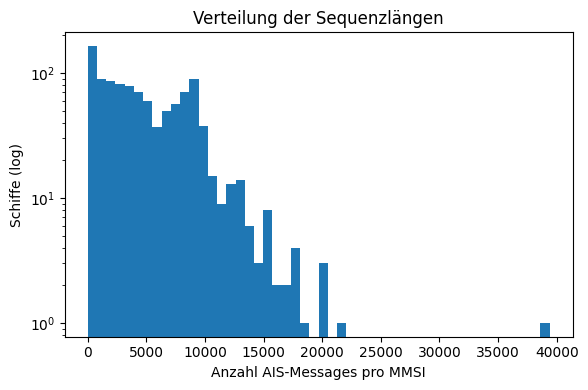

In [63]:
# 1.2) Sequenzlängen pro MMSI zählen
seq_lens = df.groupby("MMSI").size().rename("count")
print("Sequenzlängen (Top 10 Schiffe):")
print(seq_lens.sort_values(ascending=False).head(10))

# 1.3) Verteilung der Sequenzlängen ansehen
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(seq_lens, bins=50, log=True)
plt.xlabel("Anzahl AIS-Messages pro MMSI")
plt.ylabel("Schiffe (log)")
plt.title("Verteilung der Sequenzlängen")
plt.tight_layout()
plt.show()

In [67]:
# 2) Schiffe mit weniger als 20 Meldungen herausfiltern
few = seq_lens[seq_lens < 20]

# 3) Ergebnis ausgeben
print(f"Anzahl Schiffe mit < 20 Meldungen: {few.count():,}")
print("\nBeispiele (MMSI: Anzahl):")
print(few.sort_values().head(10))

Anzahl Schiffe mit < 20 Meldungen: 15

Beispiele (MMSI: Anzahl):
MMSI
236112059    1
244100025    1
249605000    2
255806177    2
211846360    4
304091000    4
311000330    4
219024891    5
261001340    5
211603970    6
Name: count, dtype: int64


In [69]:
MIN_LEN = 20
valid_mmsi = seq_lens[seq_lens >= MIN_LEN].index
df = df[df["MMSI"].isin(valid_mmsi)]
print(f"Nach Mindestlänge ≥{MIN_LEN}: {df['MMSI'].nunique():,} Schiffe bleiben übrig.")

Nach Mindestlänge ≥20: 1,041 Schiffe bleiben übrig.


## 2. Sliding-Window-Sequenzen erzeugen

Wir übersetzen jede MMSI-Zeitreihe in eine Liste von Sequenzen der Form (L * Features)

In [57]:
from tqdm import tqdm

L = 20  # Fensterlänge
features = ["SOG", "COG", "Draught", "Width", "Length", "delta_t"]  # je nach Verfügbarkeit

X, y = [], []

for mmsi, group in tqdm(df.groupby("MMSI")):
    # Sortieren nach Zeit
    g = group.sort_values("# Timestamp").reset_index(drop=True)
    # delta_t berechnen (falls noch nicht vorhanden)
    g["delta_t"] = g["# Timestamp"].diff().dt.total_seconds().fillna(0)
    # Labels: Cargo vs. Other (für das gesamte Schiff oder Fenster? für uns Fenster=Schiff)
    label = int((g["Ship type"]=="Cargo").any())
    # Fenster erzeugen
    for start in range(0, len(g) - L + 1, L):  # nicht überlappend
        seq = g.iloc[start:start+L][features].values
        X.append(seq)
        y.append(label)

X = np.array(X)  # shape (n_sequences, L, n_features)
y = np.array(y)  # shape (n_sequences,)
print("X-Shape:", X.shape, "y-Shape:", y.shape)

100%|██████████| 1056/1056 [00:32<00:00, 32.10it/s]

X-Shape: (264883, 20, 6) y-Shape: (264883,)


### 3. Train/Test-Split & Feature-Scaling

Für RNN/TCN hilft es oft, die Features (z. B. SOG, COG, Draught) zu normalisieren.